In [ ]:
pip install torch

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import torch
from datetime import datetime
import joblib
import os

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, mean_squared_error


In [ ]:
# Load data

# Get current directory
current_dir = os.path.abspath(".")

# Filename
filename = "software_engineer_salaries.csv"

df = pd.read_csv(os.path.join(current_dir, filename))
df.head()  

### Question 1: Datasets and EDA
#### a. Dataset Preparation

##### i. Collect, preprocess, and prepare a dataset for the custom task.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

all_benefits = df["AdditionalBenefits"].dropna().apply(lambda x: [b.strip() for b in str(x).split(";")])
benefits_array = [item for sublist in all_benefits for item in sublist]
unique_benefits = list(set(benefits_array))

# Feature engineering: Extract key benefits as binary flags
for benefit in unique_benefits:
    df[benefit] = df["AdditionalBenefits"].apply(lambda x: 1 if benefit in str(x) else 0)

# Drop redundant columns
df = df.drop(columns=["AdditionalBenefits"])

# Preprocessing pipeline
# Categorical features will be one-hot encoded
# Numerical features will be scaled
# This is necessary for the ANN to work properly
categorical_columns = ['Gender', 'RemoteOnsite', 'Industry', 'Education', 'Location', 'JobTitle']
numerical_columns = ['ExperienceYears', 'Certifications', 'PreviousCompanies', 'Age', 'CompanySize', 'SalaryUSD']

# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

# --------------------------
#  Separate features and target
# --------------------------
X = df.drop(columns=["SalaryUSD"])   # Features except the salary (target variable)
y = df["SalaryUSD"]                  # Target (regression)

# print("Processed feature shape:", X.shape)
print("Features:\n", X.head().transpose())
print("Target:\n", y.head().transpose())


##### ii. Describe the nature and characteristics of the collected datasets and provide a comprehensive EDA of the dataset.

In [5]:
# statistics for numerical columns
num_summary = df[['SalaryUSD']].describe().transpose()
print(num_summary)

             count           mean            std      min       25%       50%  \
SalaryUSD  30000.0  158354.172033  104106.608303  10669.0  64072.75  146685.0   

                 75%       max  
SalaryUSD  224393.25  744333.0  


In [ ]:
full_df_details = df.describe().transpose()
print(full_df_details)

In [ ]:
# Check for missing values
null_columns = df.isnull().sum()
print(null_columns)

In [ ]:
# Correlation matrix for numerical features
correlation_matrix = df.corr(numeric_only=True)
print("Correlation matrix:\n", correlation_matrix)

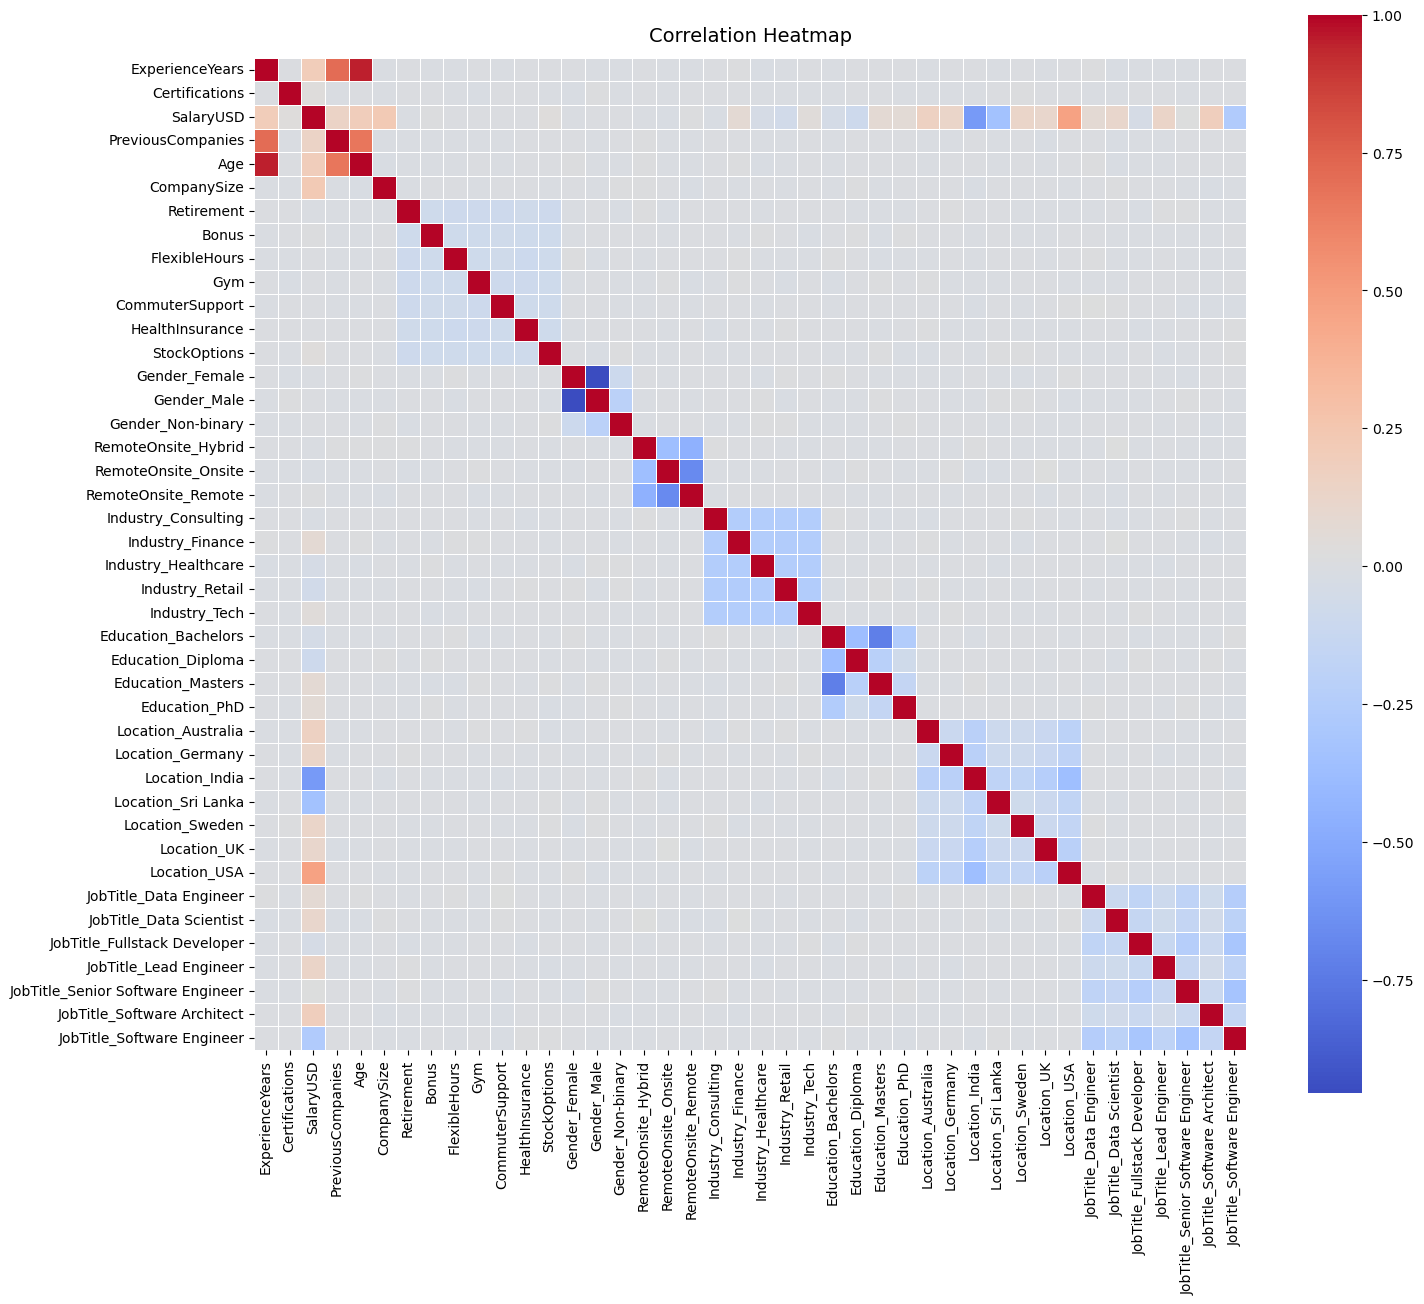

In [22]:
import seaborn as sns

# set up the figure
plt.figure(figsize=(16, 14)) 

# draw the heatmap
sns.heatmap(
    correlation_matrix,  # only strong ones
    annot=False,        # show correlation values in cells
    fmt=".2f",         # format to 2 decimal places
    cmap="coolwarm",   # color palette
    cbar=True,         # show color bar
    square=True,       # keep cells square-shaped
    linewidths=0.5
)

plt.title("Correlation Heatmap", fontsize=14, pad=12)
#plt.tight_layout()
plt.show()

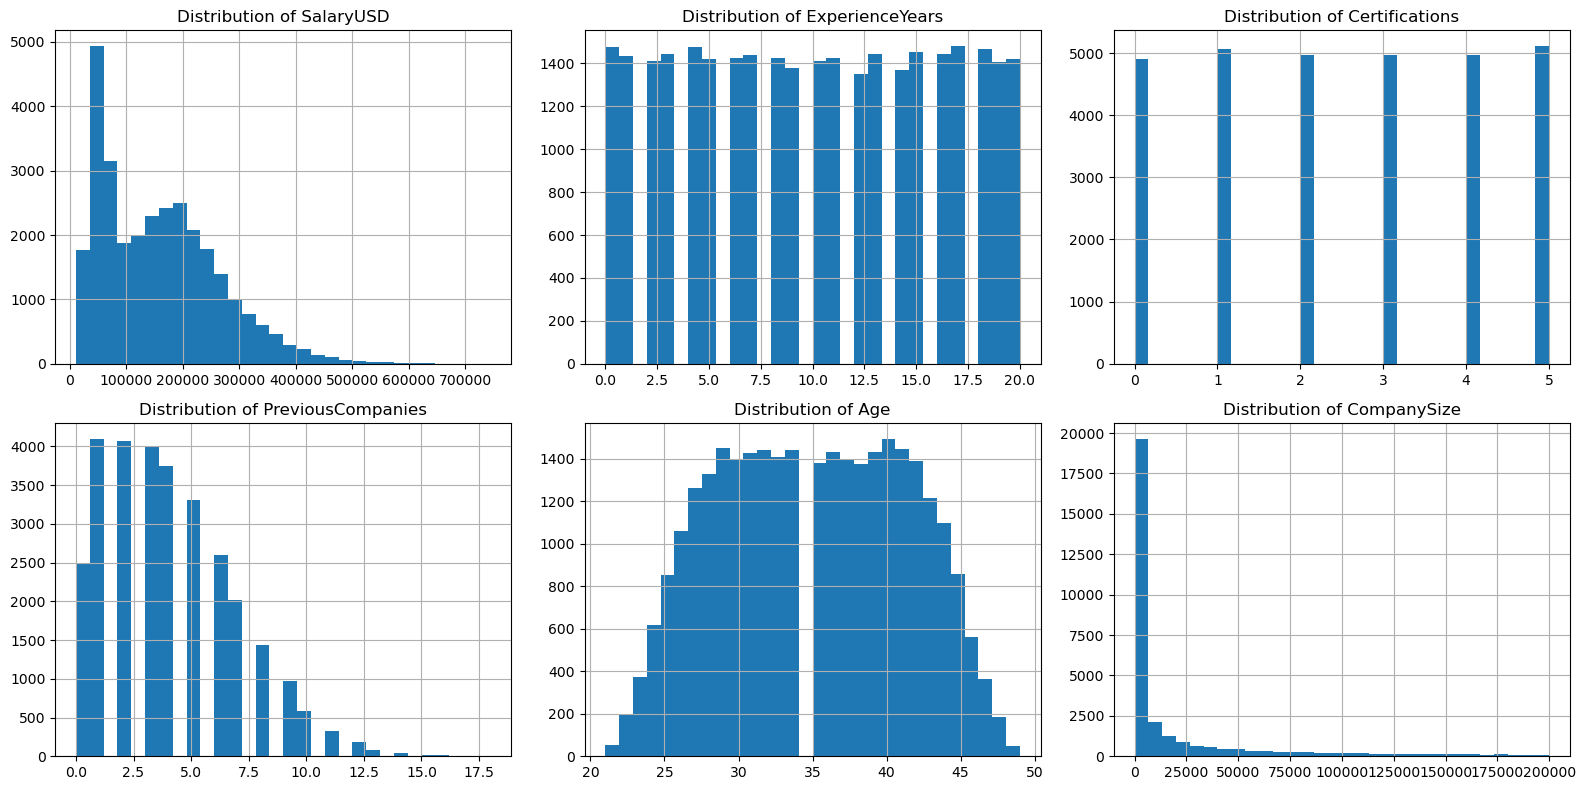

In [9]:
# Plot distributions for key numerical features
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.ravel()
for i, col in enumerate(["SalaryUSD", "ExperienceYears", "Certifications", "PreviousCompanies", "Age", "CompanySize"]):
    df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

#### Scaled the preprocessed data using transformers and save to disk for later use in inferencing

In [5]:
# Split the dataset into train (60%), temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize Scalers
feature_scaler = StandardScaler()
target_scaler  = StandardScaler()

# Fit feature scaler only on train features and transform train, val, test features
X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val) # Use transform, not fit_transform
X_test_scaled = feature_scaler.transform(X_test) # Use transform, not fit_transform

# save the X features files
np.save(os.path.join(current_dir, 'model', 'X_train_scaled.npy'), X_train_scaled)  # Saves in binary .npy format
np.save(os.path.join(current_dir, 'model', 'X_val_scaled.npy'), X_val_scaled)  # Saves in binary .npy format
np.save(os.path.join(current_dir, 'model', 'X_test_scaled.npy'), X_test_scaled)  # Saves in binary .npy format

# Reshape target arrays if needed (fit_transform expects 2D array)
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Fit target scaler only on train target and transform train, val, test targets
y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)

# Save scalers to disk
joblib.dump(feature_scaler, os.path.join(current_dir, 'model', 'feature_scaler.joblib'))
joblib.dump(target_scaler, os.path.join(current_dir, 'model', 'target_scaler.joblib'))

# Now the scaled datasets are ready for model training and evaluation
print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)


X_train_scaled shape: (18000, 41)
y_train_scaled shape: (18000, 1)


In [ ]:
# Now create PyTorch tensors
X_tr_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)

X_te_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_te_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).view(-1, 1)

print("Train set shape:", X_tr_tensor.shape, y_tr_tensor.shape)
print("Test set shape:", X_te_tensor.shape, y_te_tensor.shape)
print("Validation set shape:", X_val_tensor.shape, y_val_tensor.shape)

Train set shape: torch.Size([18000, 41]) torch.Size([18000, 1])
Test set shape: torch.Size([6000, 41]) torch.Size([6000, 1])
Validation set shape: torch.Size([6000, 41]) torch.Size([6000, 1])


#### Define the Neural Network Model

In [ ]:
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.network = nn.Sequential(

            #First Layer
            nn.Linear(input_size, 128),     # Input layer to 128 neurons
            nn.BatchNorm1d(128), # keeps training activations under control
            nn.ReLU(),       # ReLU activation function
            nn.Dropout(p=0.2), # force the model not to cheat by memorizing

            # Second Layer
            nn.Linear(128, 64),    # 128 neurons to 64 neurons
            nn.BatchNorm1d(64),
            nn.ReLU(),       # Another ReLU
            nn.Dropout(p=0.2),

            # Third Layer
            nn.Linear(64, 32),    # 64 neurons to 32 neurons
            nn.BatchNorm1d(32),
            nn.ReLU(),       # Another ReLU
            nn.Dropout(p=0.2),

            # Fourth and the final Layer
            nn.Linear(32, 1),     # Output layer to 1 neurons (classes)
        )

    def forward(self, x):
        return self.network(x)
    

#### Define the Train Function

In [8]:
import math
from torch.utils.data import DataLoader, TensorDataset

running_loss = 0.0

# Define the training function
def train(model, device, train_loader, criterion, optimizer, epoch): 
    global running_loss
    model.train()    

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 200 == 0:
            print(f'Train Loss: {running_loss / 200:.4f}')
            running_loss = 0.0


#### Define the test function

In [9]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Will disable the gradient calculation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_loss_value = test_loss / len(test_loader)
    print(f'Test Loss: {test_loss_value:.4f}')
    return all_preds, all_labels, test_loss_value

#### Define the Validation Function

In [10]:
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Will disable the gradient calculation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_loss_cal = val_loss / len(val_loader)
    print(f'Validation Loss: {val_loss_cal:.4f}')
    return all_preds, all_labels, val_loss_cal

#### Early Stopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, delta=0, path="optimized_model.pt"):
        """
        Args:
            patience (int): How many epochs to wait after last improvement.
            delta (float): Minimum change to qualify as an improvement.
            path (str): Where to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_loss = np.Inf
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            torch.save(model.state_dict(), self.path)  # Save best model
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


#### Train and Evaluating the Model

In [ ]:
epochs = 100
learning_rate = 0.001
batch_size = 64

# Create train DataLoaders
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# create DataLoader for test set
test_dataset = TensorDataset(X_te_tensor, y_te_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# create DataLoader for test set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Create an instance of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running Device: {device}")
model = FullyConnectedNeuralNetwork(X_tr_tensor.shape[1]).to(device)
print(model)

# Setup loss function and optimizer
criterion = nn.MSELoss() # mean squared error
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Track training losses
train_losses = []
test_losses = []
val_losses = []
run_epochs = []

# Initialize early stopping
filename = f"optimized_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt"
model_file_path = os.path.join(current_dir, 'model', filename)
early_stopping = EarlyStopping(patience=20, delta=1e-4, path=model_file_path)

# Train the model
for epoch in range(1, epochs + 1):

    run_epochs.append(epoch)
    print(f'Epoch {epoch} - Training Started')

    # Train the model
    train(model, device, train_loader, criterion, optimizer, epoch)
    train_losses.append(running_loss / len(train_loader))

    # Test the model
    all_preds, all_labels, test_loss = test(model, device, test_loader, criterion)
    test_losses.append(test_loss)

    # Validate the model
    all_preds, all_labels, val_loss = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)

    # Check for early stopping
    # ---- Check early stopping ----
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

    print("-"*40)

Running Device: cpu
FullyConnectedNeuralNetwork(
  (network): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Epoch 1 - Training Started
Train Loss: 0.3797
Test Loss: 0.1246
Validation Loss: 0.1262
----------------------------------------
Epoch 2 - Training Started
Train Loss: 0.2639
Test Loss: 0.1033
Validation Loss: 0.1033
--------------------------

#### Visualizing Training Progress

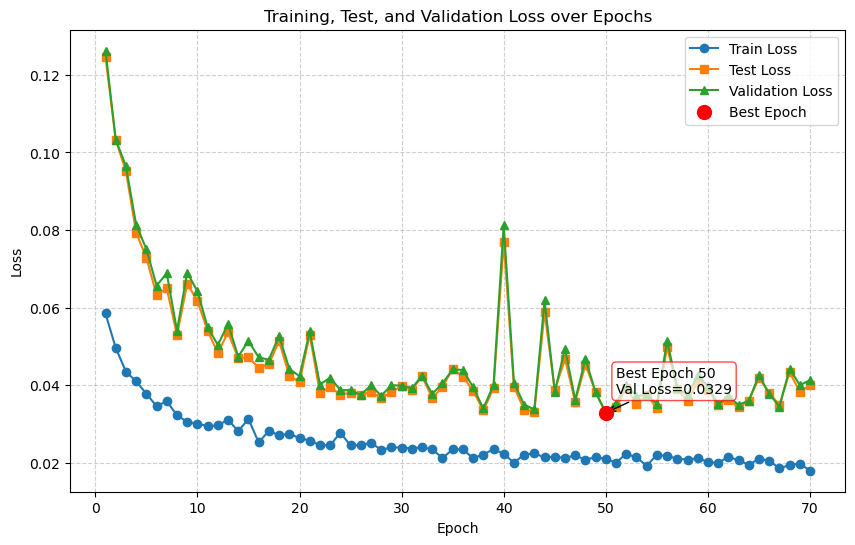

In [37]:
# Find the best epoch (minimum validation loss)
val_loss_np = np.array(val_losses)
best_epoch = run_epochs[val_loss_np.argmin()]
best_val_loss = val_loss_np.min()

# Plot
plt.figure(figsize=(10,6))
plt.plot(run_epochs, train_losses, label="Train Loss", marker="o")
plt.plot(run_epochs, test_losses, label="Test Loss", marker="s")
plt.plot(run_epochs, val_losses, label="Validation Loss", marker="^")

# Highlight best epoch
plt.scatter(best_epoch, best_val_loss, color="red", s=100, zorder=5, label="Best Epoch")
plt.annotate(
    f"Best Epoch {best_epoch}\nVal Loss={best_val_loss:.4f}",
    (best_epoch, best_val_loss),
    xytext=(best_epoch+1, best_val_loss+0.005),
    arrowprops=dict(facecolor="red", arrowstyle="->"),
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.7)
)

# Labels and style
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Test, and Validation Loss over Epochs")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

### Question 4: Web Application Implementation

##### a. Implement a simple web application (frontend/backend) that interacts with the fine-tuned model, allowing users to input and receive generated responses from the model.

Inference part implemented in inference notebook and also in the salaray prediction web app.<br/>
install dependancies --> pip install -r requirements.txt  <br/>
Web application is implemented in side Salary-predictor-web-app folder. run using this command --> "python app.py"  

### Question 4: Explainable AI

Moved to the Explainable_AI.ipynb file and also added to the salary-prediction web app.